In [16]:
import re
import pandas as pd 
import numpy as np 
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import *
stemmer = PorterStemmer()
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [3]:
train  = pd.read_csv('train_E6oV3lV.csv')

In [4]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [26]:
## Cleaning data

def clean_text(doc):
    ##1.Lower the text
    clean_text=doc.lower()
    ##2.Remove the html text
    clean_text = re.sub("@[\w]*", "", clean_text)
    clean_text = re.sub("<.*?>", "", clean_text)
    ##3.Remove the non-alpha char
    clean_text=re.sub("[^a-zA-Z]+", " ",clean_text)    
    ##4.Tokenize the text
    word_tokens = word_tokenize(clean_text) 
    filtered_sentence = [stemmer.stem(w) for w in word_tokens ]  
    filtered_sentence=" ".join(filtered_sentence)
    return filtered_sentence


In [27]:
train['token']=train['tweet'].apply(lambda x:clean_text(x))

In [32]:
train.head()

,id,label,tweet,token
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunct and is so selfish he...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank for lyft credit i can t use caus they do...
2,3,0,bihday your majesty,bihday your majesti
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguid societi now motiv


    What are the most common words in the entire dataset?
    What are the most common words in the dataset for negative and positive tweets, respectively?
    How many hashtags are there in a tweet?
    Which trends are associated with my dataset?
    Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

    A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

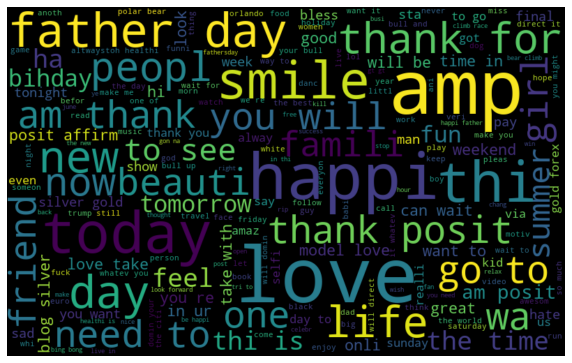

In [29]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in train['token']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

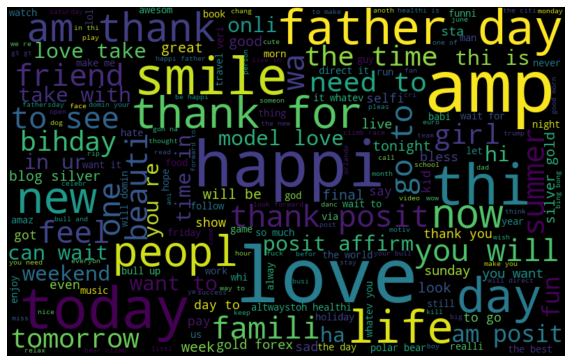

In [33]:
normal_words =' '.join([text for text in train['token'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

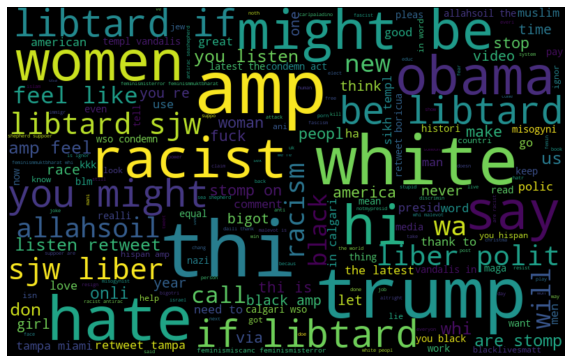

In [35]:
hatter_words =' '.join([text for text in train['token'][train['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(hatter_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [37]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [49]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(train['tweet'][train['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

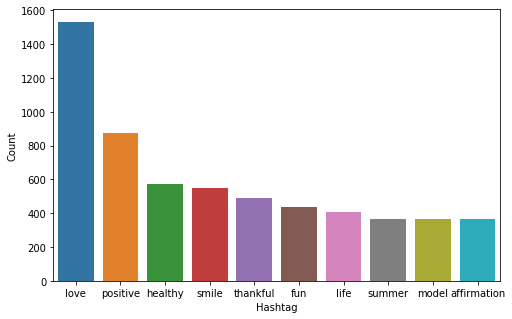

In [52]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(8,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

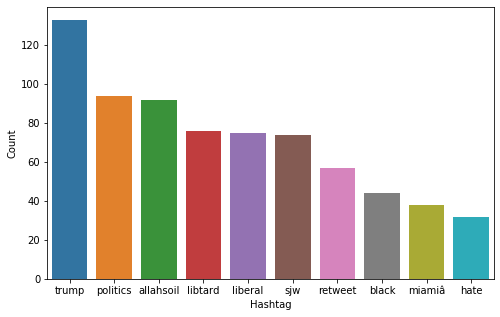

In [53]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(8,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train['token'])

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


# splitting data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(bow, train['label'], random_state=42, test_size=0.3)



In [63]:
lreg = LogisticRegression()
lreg.fit(X_train, y_train) # training the model

prediction = lreg.predict_proba(X_test) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(y_test, prediction_int) # calculating f1 score

/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5541195476575123